
# Case Study and Implementation




In [298]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Nigerian Market Sellout Prediction

## Problem Statement
In Nigerian open-air markets, small and medium enterprises (SMEs), often run by women, deal in various perishable goods. These businesses face challenges specific to the informal trade sector, such as time-of-day price fluctuations, prevalent haggling, and limited access to cold storage. Unsold inventory leads to financial losses and food waste.

## Proposed Solution
The proposed solution is to develop a machine learning model that predicts the likelihood of an item selling out in a given market session. By accurately forecasting demand, SMEs can make data-driven decisions regarding pricing, stock levels, and when to offer discounts to clear inventory before spoilage, ultimately improving their profitability.

## Dataset Description
The dataset is designed to capture key aspects of Nigerian informal market dynamics:

- **Time-of-Day Pricing**: Prices vary across morning, afternoon, and evening sessions. Morning prices are usually highest due to fresh produce and bulk buyers, while evening prices drop as sellers aim to clear their stock.

- **Bargaining Dynamics**: Prices are often negotiable and can vary based on factors such as customer loyalty, purchase volume, and the seller's eagerness to make a sale.

- **Seasonality**: The wet or dry season and whether an item is in season affect supply and demand dynamics.

- **Inventory Age**: The number of days since an item was delivered to the seller impacts its freshness and the urgency to sell.

- **Storage Methods**: The type of storage used, such as refrigeration or open-air storage, influences an item's shelf life and salability.

- **Market Context**: Factors like designated market days, ongoing religious periods, transportation disruptions, and prevailing inflation rates provide additional context for market dynamics.

### Key Features
- `Date`: Date of the market session
- `Month`: Month number
- `TimeOfDay`: Morning, Afternoon, or Evening session
- `Item`: Product category (e.g., Tomatoes, Yams, Beef)
- `PriceNaira`: Price in Nigerian Naira  
- `Quantity`: Quantity of the item
- `IsWetSeason`: Binary indicator for wet/rainy season
- `IsInSeason`: Binary indicator for whether the item is in its peak season
- `DaysSinceDelivery`: Number of days since the item was delivered to the seller
- `StorageType`: Type of storage used (e.g., Refrigerated, Open air)
- `CurrentInflationRate`: Prevailing inflation rate as a decimal
- `IsMarketDay`: Binary indicator for designated major market days
- `IsReligiousPeriod`: Binary indicator for ongoing major religious periods
- `TransportDisruption`: Binary indicator for transportation disruptions affecting supply

### Target Variable
- `SoldOut`: Binary indicator for whether the item sold out in the given session

## Importance and Uniqueness
This project is unique in its focus on the Nigerian informal trade sector and its specific dynamics. While there are existing sales forecasting models, few are tailored to the nuances of African open-air markets.

By incorporating features that capture time-of-day pricing, bargaining prevalence, seasonality, and other relevant factors, this model aims to reflect the daily realities faced by SMEs operating in this sector.

Accurate sellout predictions can enable these businesses to make informed, data-driven decisions. In a sector where many operators rely on intuition and experience alone, this model has the potential to facilitate a shift towards data-driven decision-making.

The project's importance lies in its potential to directly address the challenges of spoilage and lost revenue faced by SMEs dealing in perishable goods. By optimizing their daily operations through sellout predictions, these businesses can improve their profitability and sustainability, ultimately contributing to the broader Nigerian economy.

In [299]:
data = pd.read_csv('nigerian_market_prices_2024.csv')

data.head()

,Date,Month,TimeOfDay,Item,PriceNaira,Quantity,IsWetSeason,IsInSeason,DaysSinceDelivery,StorageType,CurrentInflationRate,IsMarketDay,IsReligiousPeriod,TransportDisruption,SoldOut
0,2024-January-01,January,Morning,Agric eggs medium size,1462.24,79,0,0,1,room,34.8,0,0,0,1
1,2024-January-01,January,Morning,Beans brown,1338.58,82,0,0,5,room,34.8,1,0,0,1
2,2024-January-01,January,Morning,Beans white black eye,1300.01,45,0,0,5,room,34.8,0,0,0,1
3,2024-January-01,January,Morning,Beef Bone in,3678.47,81,0,0,4,cold,34.8,1,0,0,1
4,2024-January-01,January,Morning,Beef boneless,6860.80,69,0,0,4,cold,34.8,1,1,0,1


### One hot encoding non-numeric columns

In [300]:
df = pd.DataFrame(data)

df_encoded = pd.get_dummies(df, columns=['TimeOfDay', 'StorageType', 'Item'])

df_encoded.head()

,Date,Month,PriceNaira,Quantity,IsWetSeason,IsInSeason,DaysSinceDelivery,CurrentInflationRate,IsMarketDay,IsReligiousPeriod,...,Item_Beans white black eye,Item_Beef Bone in,Item_Beef boneless,Item_Catfish (obokun) fresh,Item_Catfish dried,Item_Chicken Wings,Item_Onion bulb,Item_Sweet potato,Item_Tomato,Item_Yam tuber
0,2024-January-01,January,1462.24,79,0,0,1,34.8,0,0,...,False,False,False,False,False,False,False,False,False,False
1,2024-January-01,January,1338.58,82,0,0,5,34.8,1,0,...,False,False,False,False,False,False,False,False,False,False
2,2024-January-01,January,1300.01,45,0,0,5,34.8,0,0,...,True,False,False,False,False,False,False,False,False,False
3,2024-January-01,January,3678.47,81,0,0,4,34.8,1,0,...,False,True,False,False,False,False,False,False,False,False
4,2024-January-01,January,6860.80,69,0,0,4,34.8,1,1,...,False,False,True,False,False,False,False,False,False,False


In [301]:
# Dropping unecessary columns
df_encoded.drop(['Date', 'Month'], axis=1, inplace=True)

### Analyzing correlation between fearures

In [302]:
# correlation matrix
def plot_correlation_matrix(df):
    corr = df.corr()
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.show()

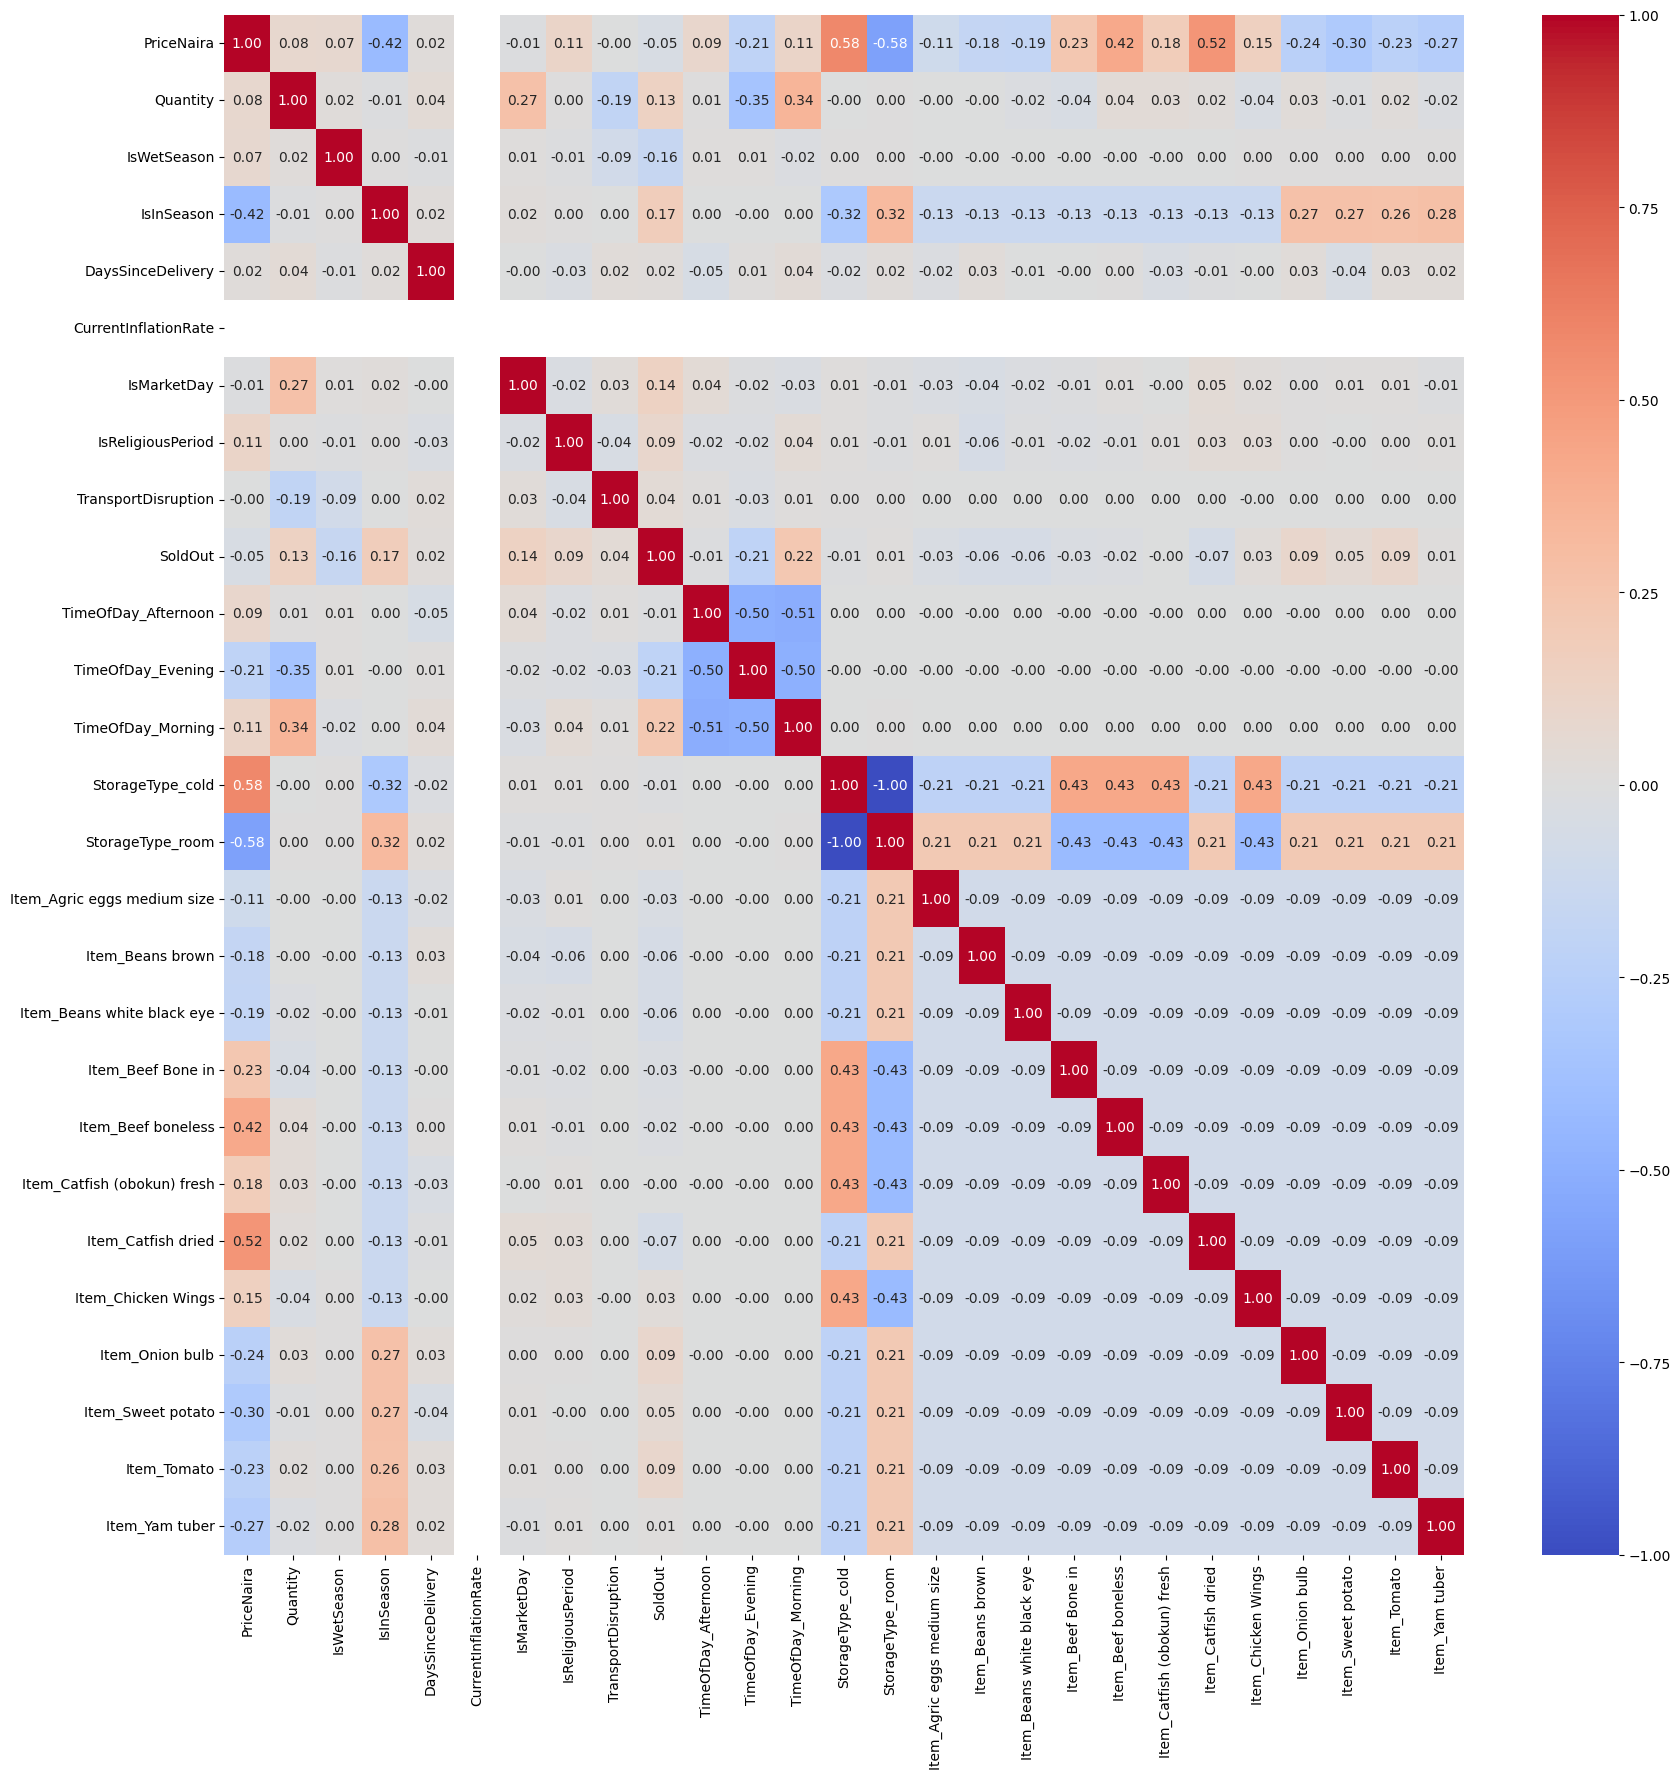

In [303]:
plot_correlation_matrix(df_encoded)

In [304]:
def get_low_corr_features(df, key_features, threshold = 0.1):
    # Calculate correlation matrix
    corr_matrix = df.corr()

    # Find low correlation features, excluding our essential features
    low_corr_features = []
    for column in corr_matrix.columns:
        if column not in key_features:  # Only check non-key features
            correlations = corr_matrix[column].drop(column).abs()
            low_corr_count = (correlations < threshold).sum()
            if low_corr_count >= len(correlations) * 0.8:
                low_corr_features.append(column)

    print('Features that could potentially be dropped (low correlation and non-essential):')
    for feat in low_corr_features:
        print(feat)

    print('\nNumber of non-essential features with low correlation:',
        len(low_corr_features))
    
    return low_corr_features, corr_matrix

In [305]:
# Update key features list to include essential categorical variables
key_features = [
    # Time of day features
    'TimeOfDay_Morning', 'TimeOfDay_Afternoon', 'TimeOfDay_Evening',

    # Item features
    'Item_Agric eggs medium size', 'Item_Beans brown', 'Item_Beans white black eye',
    'Item_Beef Bone in', 'Item_Beef boneless', 'Item_Catfish (obokun) fresh',
    'Item_Catfish dried', 'Item_Chicken Wings', 'Item_Onion bulb',
    'Item_Sweet potato', 'Item_Tomato', 'Item_Yam tuber',

    # Core features
    'PriceNaira', 'Quantity',

    # Storage types
    'StorageType_cold', 'StorageType_room',

    # Target variable
    'SoldOut'
]

df_encoded = df_encoded.drop('CurrentInflationRate', axis=1) # Inflatoin for the time period of the dataset is constant
low_corr_features, matrix = get_low_corr_features(df_encoded, key_features=key_features)

Features that could potentially be dropped (low correlation and non-essential):
IsWetSeason
DaysSinceDelivery
IsMarketDay
IsReligiousPeriod
TransportDisruption

Number of non-essential features with low correlation: 5


In [306]:
def drop_n_features(df, corr_matrix, n = 5):
    # Set constant for number of features to drop

    # Calculate average correlation for each feature
    avg_correlations = {}
    for feature in low_corr_features:
        avg_correlations[feature] = corr_matrix[feature].abs().mean()

    # Get features to drop (lowest correlations)
    features_to_drop = sorted(avg_correlations.items(),
                            key=lambda x: x[1])[:n]

    print("Features being dropped:")
    for feature, corr in features_to_drop:
        print(f"{feature}: {corr:.3f}")

    # Drop the features

    print(
        f"\nFeatures dropped: {len(features_to_drop)} out of {len(low_corr_features)} low-correlation features")

    return df.drop([f[0] for f in features_to_drop], axis=1)

In [307]:
df_encoded = drop_n_features(df_encoded, corr_matrix=matrix, n=len(low_corr_features))

Features being dropped:
IsWetSeason: 0.055
TransportDisruption: 0.057
DaysSinceDelivery: 0.058
IsReligiousPeriod: 0.063
IsMarketDay: 0.071

Features dropped: 5 out of 5 low-correlation features


### Class Imbalance Analysis

In [308]:
# Show bar graph for Time of day (TimeOfDay_Afternoon, TimeOfDay_Evening, TimeOfDay_Morning)
from pandas import DataFrame, Series


def plot_imbalance_graph(df: DataFrame, cols: list) -> None:
    plt.figure(figsize=(15, 5))

    for i, coln in enumerate(cols, 1):
        plt.subplot(1, 3, i)

        # Get value counts
        counts = df[coln].value_counts()

        # Create bar plot
        ax = counts.plot(kind='bar', color=['skyblue', 'orange'])

        # Add count labels on top of each bar
        for j, v in enumerate(counts):
            ax.text(j, v, str(v), ha='center', va='bottom')

        plt.title(f'{coln} distribution')
        plt.xticks(rotation=0)
        plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

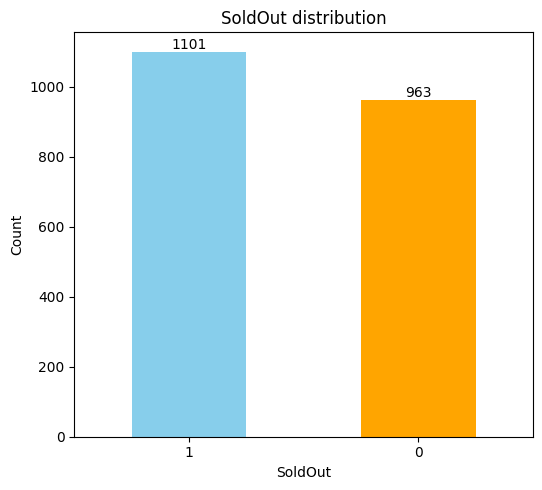

In [309]:
colns = ['SoldOut']
plot_imbalance_graph(df_encoded, colns)

In [310]:
X = df_encoded.drop('SoldOut', axis=1)
y = df_encoded['SoldOut']

In [311]:
# TO DO: Load Data (Seprate into: Train, Validation and test sets)

def get_train_test_val(X: DataFrame, y: Series) -> tuple:
    from sklearn.model_selection import train_test_split

    X_remain, X_test, y_remain, y_test = train_test_split(X, y, test_size=0.15)
    X_train, X_val, y_train, y_val = train_test_split(
        X_remain, y_remain, test_size=0.15)

    return X_train, y_train, X_test, y_test, X_val, y_val

In [312]:
X_train, y_train, X_test, y_test, X_val, y_val = get_train_test_val(X, y)

In [313]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X=X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train = np.clip(X_train, 0, 1)
X_val = np.clip(X_val, 0, 1)
X_test = np.clip(X_test, 0, 1)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((1490, 20), (264, 20), (310, 20), (1490,), (264,), (310,))

In [335]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from pandas import DataFrame, Series


def get_rf_model(X_train: DataFrame, y_train: Series) -> RandomForestClassifier:
    # Create base model
    rf_model = RandomForestClassifier(random_state=42)

    # Simple parameter grid with just a few key parameters
    param_grid = {
        'n_estimators': [50, 100],
        'max_depth': [None, 10],
        'min_samples_split': [2, 5]
    }

    try:
        # Set up GridSearchCV with minimal parameters for parameter tuning
        grid_search = GridSearchCV(
            rf_model,
            param_grid,
            cv=3,           # 3-fold cross-validation
            n_jobs=-1       # Use all available cores
        )

        # Fit the model
        grid_search.fit(X_train, y_train)

        # Print best parameters
        print(f"Best parameters: {grid_search.best_params_}")

        return grid_search.best_estimator_

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

In [315]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


def evaluate_model(model_name, model, X_test: DataFrame, y_test: Series, threshold: float = 0.5) -> dict:
    # Get probability predictions
    y_pred_proba = model.predict(X_test)
    # Convert to binary predictions using 0.5 threshold
    y_pred = (y_pred_proba >= threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)

    results = f'''\
    {model_name} Accuracy: {accuracy:.2f}
    {model_name} F1 Score: {f1:.2f}
    {model_name} Precision: {precision:.2f}
    {model_name} Recall: {recall:.2f}
    {model_name} Classification Report: {classification_rep}
    '''

    # Plotting confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(confusion, annot=True, cmap='coolwarm', fmt='d', xticklabels=[
                'Not Sold Out', 'Sold Out'], yticklabels=['Not Sold Out', 'Sold Out'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    print(
        f'------------------------------------- {model_name} Stats -------------------------------------')
    if isinstance(model, tf.keras.models.Model):
        loss = model.evaluate(X_test, y_test)[0]
        print(f'''    {model_name} Loss: {loss:.2f}''')
    print(results)

## Finding the optimal threshhold

In [316]:
from sklearn.metrics import roc_curve


def get_optimal_threshhold(model, y_test, X_test) -> float:
    y_pred_proba = model.predict(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # Find threshold that maximizes tpr - fpr
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    return optimal_threshold

### Metrics for Traditional Machine Learning Models

In [336]:
ml_model = get_rf_model(X_train, y_train)

Best parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}


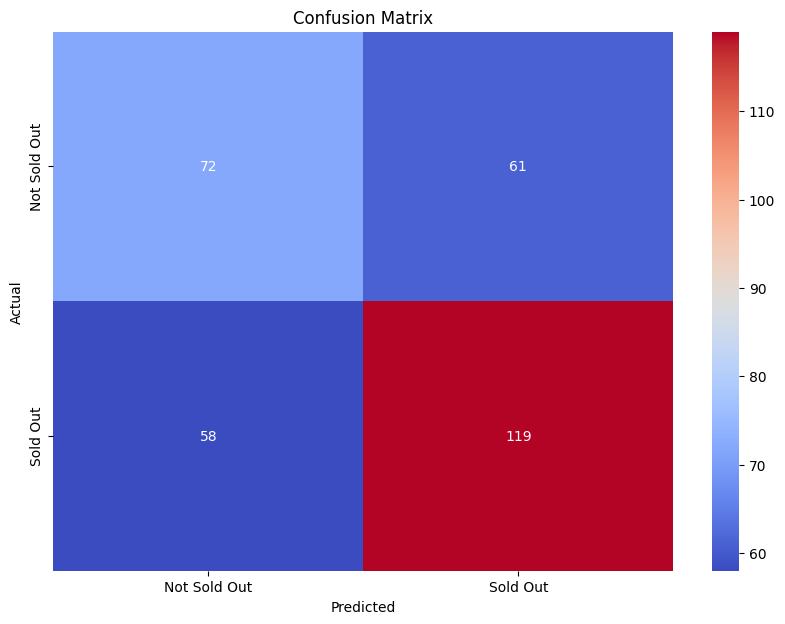

------------------------------------- Random Forest Classifier Stats -------------------------------------
    Random Forest Classifier Accuracy: 0.62
    Random Forest Classifier F1 Score: 0.67
    Random Forest Classifier Precision: 0.66
    Random Forest Classifier Recall: 0.67
    Random Forest Classifier Classification Report:               precision    recall  f1-score   support

           0       0.55      0.54      0.55       133
           1       0.66      0.67      0.67       177

    accuracy                           0.62       310
   macro avg       0.61      0.61      0.61       310
weighted avg       0.62      0.62      0.62       310

    


In [338]:
evaluate_model('Random Forest Classifier', ml_model, X_test, y_test)

#SECTION 1: Model Architecture:



```
TODO: Insert an image with the Model architecture here.Replace the image Below
```
> <img src="./architecture.png" alt="?" style="width:800px"/>




#Task: Define a function that creates models without and With specified Optimization techniques


In [319]:
def define_model(
        X_tr: DataFrame,
        y_tr: Series,
        X_val: DataFrame,
        y_val: Series,
        optimizer=tf.keras.optimizers.RMSprop,
        dropout1: float = 0,
        dropout2: float = 0,
        reg_class=None,
        stopping_patience: int = 0,
        learning_rate: float = 0.001,
        epochs: int = 100
) -> tf.keras.models.Sequential:
    '''
    Default learning rate is always 0.001 (https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/RMSprop)
    Default optimizer is always RMSprop(https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#compile)
    '''
    model = tf.keras.models.Sequential()

    # Add input layer with 512 neurons
    model.add(tf.keras.layers.Dense(
        128, activation='relu', input_shape=(X_tr.shape[1],), kernel_regularizer=reg_class))

    # Conditionally add dropout layer
    if dropout1:
        model.add(tf.keras.layers.Dropout(dropout1))

    # Hidden layer with 256 neurons
    model.add(tf.keras.layers.Dense(
        64, activation='relu', kernel_regularizer=reg_class))

    # Conditionally add dropout layer
    if dropout2:
        model.add(tf.keras.layers.Dropout(dropout2))

    # Hidden layer with 128 neurons
    # model.add(tf.keras.layers.Dense(
    #     128, activation='relu', kernel_regularizer=reg_class))

    # Conditionally add dropout layer
    # if dropout3:
    #     model.add(tf.keras.layers.Dropout(dropout3))

    # Hidden layer with 64 neurons
    model.add(tf.keras.layers.Dense(
        32, activation='relu', kernel_regularizer=reg_class))

    # Output layer
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    opt = optimizer(learning_rate=learning_rate)

    model.compile(optimizer=opt, metrics=[
                  'accuracy'], loss='binary_crossentropy')

    callback = []

    if stopping_patience:
        callback.append(tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=stopping_patience,
            restore_best_weights=True
        ))

    model.fit(X_tr, y_tr, epochs=epochs, validation_data=(
        X_val, y_val), callbacks=callback)

    return model

# Task: Print out the Final Model Accuracy and plot the Loss curve

In [320]:
def loss_curve_plot(epochs, loss, val_loss) -> None:
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

Epoch 1/45


/Users/apple/Documents/dev/ALU/Intro_ML_Summative/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5691 - loss: 0.6807 - val_accuracy: 0.6402 - val_loss: 0.6431
Epoch 2/45
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6238 - loss: 0.6535 - val_accuracy: 0.6212 - val_loss: 0.6421
Epoch 3/45
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6420 - loss: 0.6446 - val_accuracy: 0.5947 - val_loss: 0.6564
Epoch 4/45
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6178 - loss: 0.6523 - val_accuracy: 0.6402 - val_loss: 0.6355
Epoch 5/45
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6526 - loss: 0.6392 - val_accuracy: 0.6402 - val_loss: 0.6353
Epoch 6/45
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6423 - loss: 0.6404 - val_accuracy: 0.6553 - val_loss: 0.6250
Epoch 7/45
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6457 - loss: 0.6301 - val_accuracy: 0.6402 - val_loss: 0.6406
Epoch 8/45
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6364 - loss: 0.6415 - val_accuracy: 0.6439 - val_loss: 0.6340
Epo

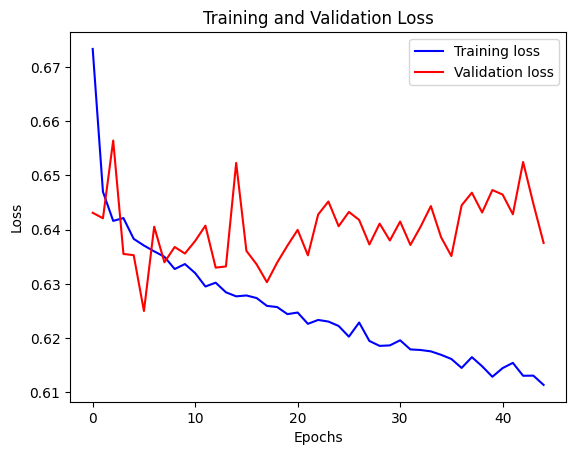

In [321]:
# Vanilla model not techniques used to improve performance
model_1 = define_model(X_train, y_train, X_val, y_val, epochs=45)
loss_curve_plot(model_1.history.epoch,
                model_1.history.history['loss'], model_1.history.history['val_loss'])

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


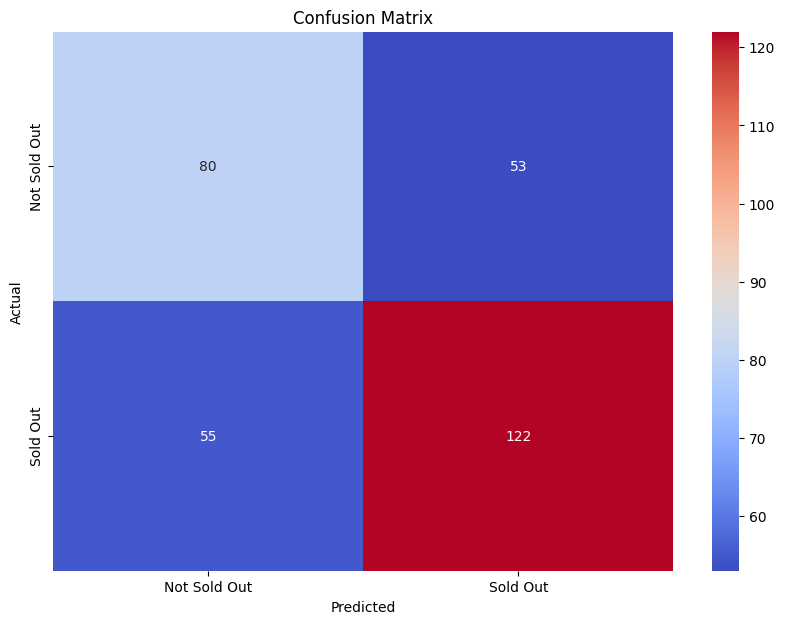

------------------------------------- Vanilla Neural Net Stats -------------------------------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6589 - loss: 0.6189 
    Vanilla Neural Net Loss: 0.64
    Vanilla Neural Net Accuracy: 0.65
    Vanilla Neural Net F1 Score: 0.69
    Vanilla Neural Net Precision: 0.70
    Vanilla Neural Net Recall: 0.69
    Vanilla Neural Net Classification Report:               precision    recall  f1-score   support

           0       0.59      0.60      0.60       133
           1       0.70      0.69      0.69       177

    accuracy                           0.65       310
   macro avg       0.64      0.65      0.65       310
weighted avg       0.65      0.65      0.65       310

    


In [322]:
evaluate_model('Vanilla Neural Net', model_1, X_test, y_test,
               threshold=get_optimal_threshhold(model_1, y_test, X_test))

Epoch 1/500


/Users/apple/Documents/dev/ALU/Intro_ML_Summative/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5669 - loss: 0.8604 - val_accuracy: 0.6136 - val_loss: 0.8201
Epoch 2/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6308 - loss: 0.8088 - val_accuracy: 0.6477 - val_loss: 0.7729
Epoch 3/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6338 - loss: 0.7839 - val_accuracy: 0.6515 - val_loss: 0.7488
Epoch 4/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6296 - loss: 0.7584 - val_accuracy: 0.6402 - val_loss: 0.7377
Epoch 5/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6407 - loss: 0.7398 - val_accuracy: 0.6402 - val_loss: 0.7251
Epoch 6/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6313 - loss: 0.7334 - val_accuracy: 0.6591 - val_loss: 0.7100
Epoch 7/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6396 - loss: 0.7201 - val_accuracy: 0.6439 - val_loss: 0.7076
Epoch 8/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6500 - loss: 0.7077 - val_accuracy: 0.6402 - val_loss: 0.7

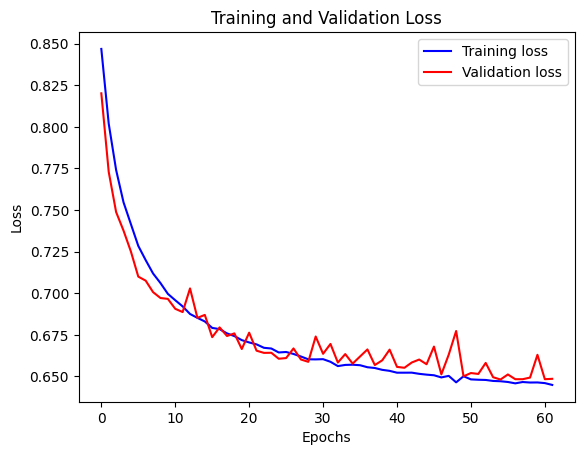

In [323]:
# Training Notes
# 1. This model is extremely sensitive to changes in the l2 regularization parameter. The optimal value for the cinfusion matrix was found to be 0.00113
# 2. At high learning rates the model seems to be quite unpredictable, erratic even shouwing 0 True Positives and 0 False Negatives
# 3. The min max scaler mad a huge difference in the model's perfomance regarding loss
model_2 = define_model(
    X_train,
    y_train,
    X_val,
    y_val,
    reg_class=tf.keras.regularizers.l2(0.00113),
    stopping_patience=7,
    learning_rate=0.00068,
    epochs=500
)
loss_curve_plot(model_2.history.epoch,
                model_2.history.history['loss'],
                model_2.history.history['val_loss']
                )

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


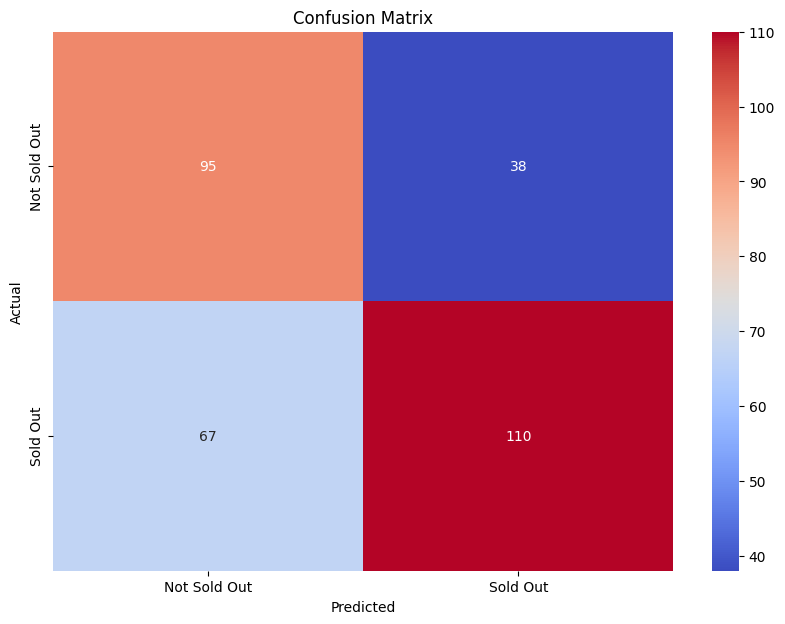

------------------------------------- Neural Net with Dropout and L2 Regularization Stats -------------------------------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6804 - loss: 0.6380 
    Neural Net with Dropout and L2 Regularization Loss: 0.65
    Neural Net with Dropout and L2 Regularization Accuracy: 0.66
    Neural Net with Dropout and L2 Regularization F1 Score: 0.68
    Neural Net with Dropout and L2 Regularization Precision: 0.74
    Neural Net with Dropout and L2 Regularization Recall: 0.62
    Neural Net with Dropout and L2 Regularization Classification Report:               precision    recall  f1-score   support

           0       0.59      0.71      0.64       133
           1       0.74      0.62      0.68       177

    accuracy                           0.66       310
   macro avg       0.66      0.67      0.66       310
weighted avg       0.68      0.66      0.66       310

    


In [324]:
evaluate_model('Neural Net with Dropout and L2 Regularization',
               model_2, X_test, y_test, threshold=get_optimal_threshhold(model_2, y_test, X_test))

Epoch 1/500


/Users/apple/Documents/dev/ALU/Intro_ML_Summative/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5493 - loss: 1.0317 - val_accuracy: 0.6250 - val_loss: 0.9501
Epoch 2/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6338 - loss: 0.9317 - val_accuracy: 0.6705 - val_loss: 0.8834
Epoch 3/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6194 - loss: 0.8987 - val_accuracy: 0.6288 - val_loss: 0.8455
Epoch 4/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6621 - loss: 0.8282 - val_accuracy: 0.6364 - val_loss: 0.8192
Epoch 5/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6359 - loss: 0.8199 - val_accuracy: 0.6288 - val_loss: 0.8012
Epoch 6/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6471 - loss: 0.7818 - val_accuracy: 0.6250 - val_loss: 0.7839
Epoch 7/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6307 - loss: 0.7769 - val_accuracy: 0.6326 - val_loss: 0.7694
Epoch 8/500
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6209 - loss: 0.7733 - val_accuracy: 0.6326 - val_loss: 0.7

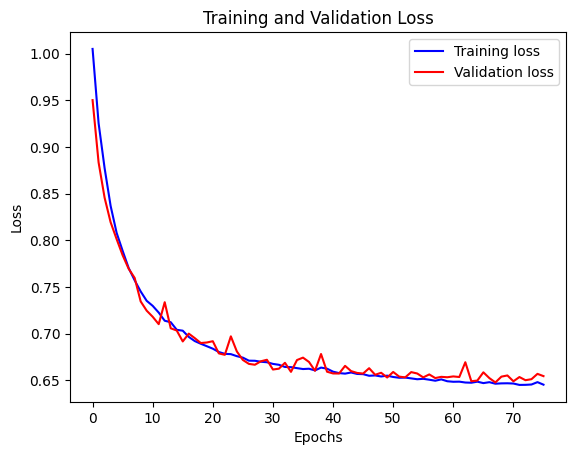

In [325]:
# Training notes
# 1. High L1 regularization > 0.0009 leads to increase in False Positives
# 2. Not using L1 reg leads to overfitting and high loss
# 3. Higher learning rate least to atronomical loss and overfitting
model_3 = define_model(
    X_train,
    y_train,
    X_val,
    y_val,
    optimizer=tf.keras.optimizers.Adam,
    # dropout1=0.1,
    reg_class=tf.keras.regularizers.L1(0.0003),
    stopping_patience=8,
    learning_rate=0.0009,
    epochs=500
)
loss_curve_plot(model_3.history.epoch,
                model_3.history.history['loss'], model_3.history.history['val_loss'])

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


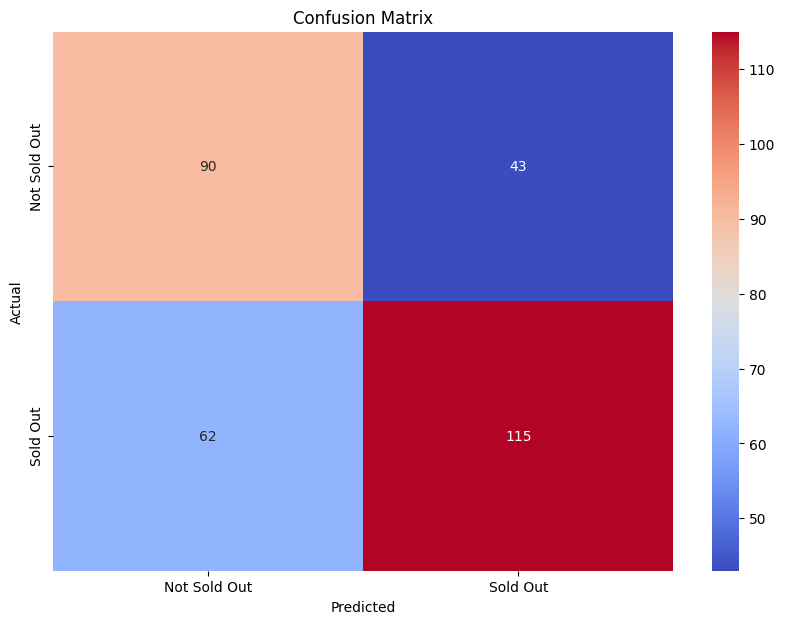

------------------------------------- Neural Net with L1 Regularization Stats -------------------------------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6713 - loss: 0.6357 
    Neural Net with L1 Regularization Loss: 0.65
    Neural Net with L1 Regularization Accuracy: 0.66
    Neural Net with L1 Regularization F1 Score: 0.69
    Neural Net with L1 Regularization Precision: 0.73
    Neural Net with L1 Regularization Recall: 0.65
    Neural Net with L1 Regularization Classification Report:               precision    recall  f1-score   support

           0       0.59      0.68      0.63       133
           1       0.73      0.65      0.69       177

    accuracy                           0.66       310
   macro avg       0.66      0.66      0.66       310
weighted avg       0.67      0.66      0.66       310

    


In [326]:
evaluate_model('Neural Net with L1 Regularization', model_3, X_test,
               y_test, threshold=get_optimal_threshhold(model_3, y_test, X_test))

Epoch 1/1000


/Users/apple/Documents/dev/ALU/Intro_ML_Summative/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5077 - loss: 1.2118 - val_accuracy: 0.6288 - val_loss: 1.1323
Epoch 2/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6033 - loss: 1.1206 - val_accuracy: 0.6212 - val_loss: 1.0508
Epoch 3/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6173 - loss: 1.0410 - val_accuracy: 0.6477 - val_loss: 0.9905
Epoch 4/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6330 - loss: 0.9790 - val_accuracy: 0.6288 - val_loss: 0.9466
Epoch 5/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6477 - loss: 0.9345 - val_accuracy: 0.6364 - val_loss: 0.9015
Epoch 6/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6417 - loss: 0.8968 - val_accuracy: 0.6288 - val_loss: 0.8817
Epoch 7/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6431 - loss: 0.8655 - val_accuracy: 0.6364 - val_loss: 0.8432
Epoch 8/1000
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6244 - loss: 0.8493 - val_accuracy: 0.6326 - val_lo

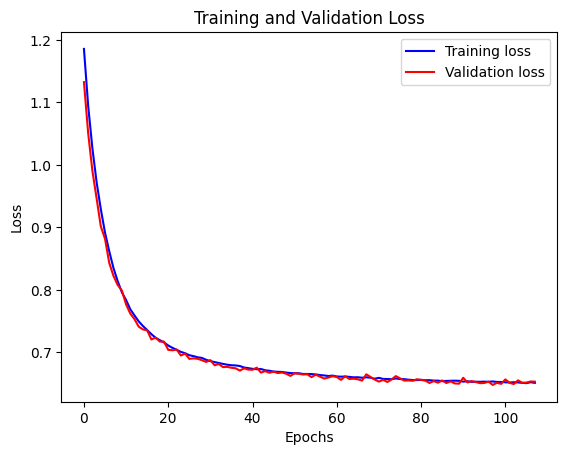

In [327]:
# Training notes
# 1. L1L2 regularization seems to be the best for this model
# 2. High learning rate leads to high loss
# 3. High L1L2 regularization leads to high loss
model_4 = define_model(
    X_train,
    y_train,
    X_val,
    y_val,
    optimizer=tf.keras.optimizers.Adam,
    reg_class=tf.keras.regularizers.L1L2(0.0003, 0.001),
    stopping_patience=10,
    learning_rate=0.00045,
    epochs=1000
)
loss_curve_plot(model_4.history.epoch,
                model_4.history.history['loss'], model_4.history.history['val_loss'])

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


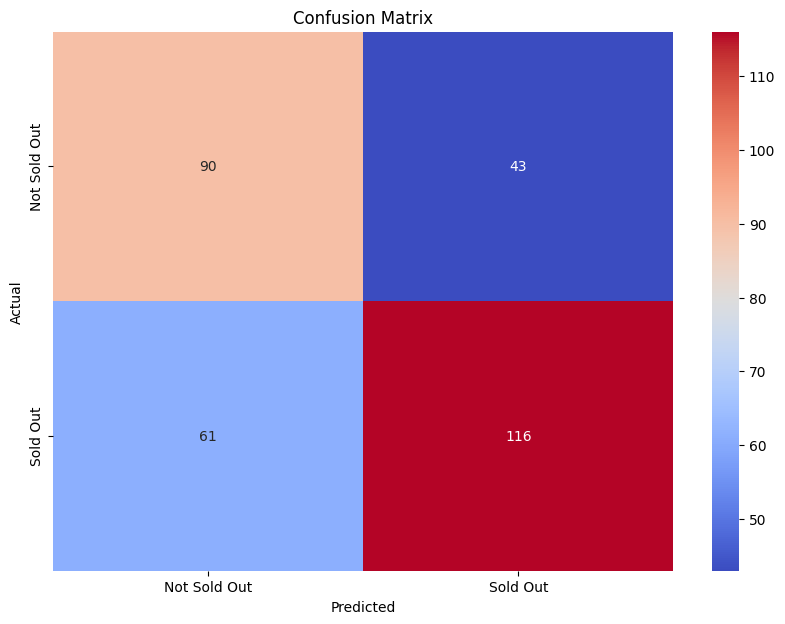

------------------------------------- Best Performing Neural Net Stats -------------------------------------
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6913 - loss: 0.6342 
    Best Performing Neural Net Loss: 0.65
    Best Performing Neural Net Accuracy: 0.66
    Best Performing Neural Net F1 Score: 0.69
    Best Performing Neural Net Precision: 0.73
    Best Performing Neural Net Recall: 0.66
    Best Performing Neural Net Classification Report:               precision    recall  f1-score   support

           0       0.60      0.68      0.63       133
           1       0.73      0.66      0.69       177

    accuracy                           0.66       310
   macro avg       0.66      0.67      0.66       310
weighted avg       0.67      0.66      0.67       310

    


In [328]:
evaluate_model('Best Performing Neural Net', model_4, X_test,
               y_test, threshold=get_optimal_threshhold(model_4, y_test, X_test))

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [329]:
import os
import joblib


def save_model(model, model_name, path='saved_models'):
    # Create directory if it doesn't exist
    if not os.path.exists(path):
        os.makedirs(path)

    # Define the full path
    model_path = os.path.join(path, f'{model_name}.keras')

    # Check if the model is a Keras model or a traditional model
    if isinstance(model, tf.keras.models.Model):
        # Save the Keras model
        model.save(model_path)
        print(f'Keras model saved at {model_path}')
    else:
        # Save the traditional model using joblib
        model_path = os.path.join(path, f'{model_name}.pkl')
        joblib.dump(model, model_path)
        print(f'Traditional model saved at {model_path}')

## Saving models

In [330]:
# Save the best performing model
models = [ml_model, model_1, model_2, model_3, model_4]
model_names = ['Random_Forest_Classifier', 'Vanilla_Neural_Net', 'Neural_Net_with_Dropout_and_L2_Regularization',
               'Neural_Net_with_L1_Regularization', 'Best_Performing_Neural_Net']
for m, n in zip(models, model_names):
    save_model(m, n)

Traditional model saved at saved_models/Random_Forest_Classifier.pkl
Keras model saved at saved_models/Vanilla_Neural_Net.keras
Keras model saved at saved_models/Neural_Net_with_Dropout_and_L2_Regularization.keras
Keras model saved at saved_models/Neural_Net_with_L1_Regularization.keras
Keras model saved at saved_models/Best_Performing_Neural_Net.keras


In [331]:
import joblib


def make_predictions(model_path, X):

    # Check if the model is a Keras model or a traditional model
    if model_path.endswith('.keras'):
        # Load the Keras model
        model = tf.keras.models.load_model(model_path)
        # Make predictions
        predictions = model.predict(X)
    else:
        # Load the traditional model using joblib
        model = joblib.load(model_path)
        # Make predictions
        # Assuming binary classification
        predictions = model.predict(X)

    threshold = get_optimal_threshhold(model, y_test, X_test)

    # Convert to binary predictions using 0.5 threshold
    y_pred = (predictions >= threshold).astype(int)

    return y_pred

In [332]:
best_performing_model = f'saved_models/{model_names[0]}.pkl'
pred_y = make_predictions(best_performing_model, X_test)
pred_y

array([1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,

Congratulations!!
